<a href="https://colab.research.google.com/github/JibrilTheUltimateFlugel/TensorflowTest/blob/main/TensorflowCNNGradientTape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plot
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.initializers import RandomNormal

In [8]:
#Load and preprocess training data
(train_img, train_lab), (test_img, test_lab) = cifar10.load_data()
train_img = (train_img / 255).reshape((-1, 32, 32, 3))
train_lab = tf.keras.utils.to_categorical(train_lab, 10)
test_img = (test_img / 255).reshape((-1, 32, 32, 3))
test_lab = tf.keras.utils.to_categorical(test_lab, 10)

In [9]:
print(train_img.shape)
print(test_img.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [14]:
#Hyperparameters
batch_size = 128
epochs = 50
optimizer = Adam(lr=0.001)
weight_init = RandomNormal()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [16]:
#Ver 2.0 Using tf.data.Dataset and batching as well as shuffling
train_dataset = tf.data.Dataset.from_tensor_slices((train_img,train_lab))
train_dataset = train_dataset.shuffle(50000).batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((test_img,test_lab))
test_dataset = test_dataset.shuffle(10000).batch(128)

In [21]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential

# Build model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=weight_init, input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=weight_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer=weight_init))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer=weight_init))

In [22]:
#Define step function
def step(real_img, real_lab):
    with tf.GradientTape() as tape:
        # Make prediction
        pred_lab = model(real_img.reshape((-1, 32, 32, 3)))
        # Calculate loss
        model_loss = tf.keras.losses.categorical_crossentropy(real_lab, pred_lab)
    
    # Calculate gradients
    model_gradients = tape.gradient(model_loss, model.trainable_variables)
    # Update model
    optimizer.apply_gradients(zip(model_gradients, model.trainable_variables))

In [23]:
import math

# Training loop
bat_per_epoch = math.floor(len(train_img) / batch_size)
for epoch in range(epochs):
    print('=', end='')
    for i in range(bat_per_epoch):
        n = i*batch_size
        step(train_img[n:n+batch_size], train_lab[n:n+batch_size])

In [33]:
# Calculate accuracy
model.compile(optimizer=optimizer, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
print('\n', model.evaluate(test_img, test_lab, verbose=0)[1])


 0.7032999992370605


In [34]:
#Now use the datasets to fit to the model!
history = model.fit(train_dataset,epochs=50,validation_data=(test_dataset))
#model.save('cnnfromscratch.h5')

Epoch 1/50
391/391 [==============================] - 9s 22ms/step - loss: 0.3001 - accuracy: 0.8881 - val_loss: 1.2111 - val_accuracy: 0.7065
Epoch 2/50
391/391 [==============================] - 6s 13ms/step - loss: 0.2914 - accuracy: 0.8944 - val_loss: 1.2541 - val_accuracy: 0.7055
Epoch 3/50
391/391 [==============================] - 6s 13ms/step - loss: 0.2926 - accuracy: 0.8939 - val_loss: 1.2016 - val_accuracy: 0.7050
Epoch 4/50
391/391 [==============================] - 6s 13ms/step - loss: 0.2861 - accuracy: 0.8947 - val_loss: 1.1870 - val_accuracy: 0.7081
Epoch 5/50
391/391 [==============================] - 6s 13ms/step - loss: 0.2857 - accuracy: 0.8949 - val_loss: 1.2277 - val_accuracy: 0.7039
Epoch 6/50
391/391 [==============================] - 6s 13ms/step - loss: 0.2775 - accuracy: 0.8983 - val_loss: 1.2115 - val_accuracy: 0.7084
Epoch 7/50
391/391 [==============================] - 6s 13ms/step - loss: 0.2802 - accuracy: 0.8968 - val_loss: 1.1772 - val_accuracy: 0.7108

In [35]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plot.subplot(211)
	plot.title('Cross Entropy Loss')
	plot.plot(history.history['loss'], color='blue', label='train')
	plot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plot.subplot(212)
	plot.title('Classification Accuracy')
	plot.plot(history.history['accuracy'], color='blue', label='train')
	plot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	#filename = sys.argv[0].split('/')[-1]
	#pyplot.savefig(filename + '_plot.png')
	#pyplot.close()

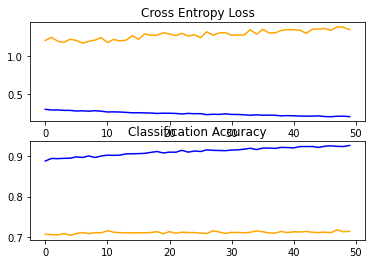

In [36]:
summarize_diagnostics(history)

In [37]:
#Evaluating the model with training dataset
loss, accuracy = model.evaluate(train_dataset)
print("Loss:", loss)
print("Accuracy:", accuracy)

391/391 [==============================] - 7s 16ms/step - loss: 0.0060 - accuracy: 1.0000
Loss: 0.0059892479330301285
Accuracy: 0.9999799728393555


In [38]:
#Evaluating the model with testing dataset
loss, accuracy = model.evaluate(test_dataset)
print("Loss:", loss)
print("Accuracy:", accuracy)

79/79 [==============================] - 1s 7ms/step - loss: 1.3545 - accuracy: 0.7137
Loss: 1.3544788360595703
Accuracy: 0.713699996471405


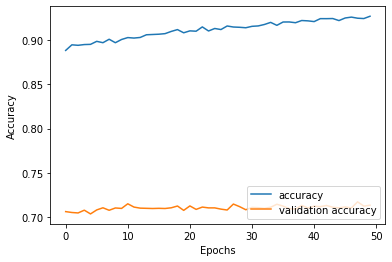

In [43]:
plot.plot(history.history['accuracy'], label='accuracy') 
plot.plot(history.history['val_accuracy'], label='validation accuracy')
plot.xlabel('Epochs')
plot.ylabel('Accuracy')
plot.legend(loc = 'lower right')

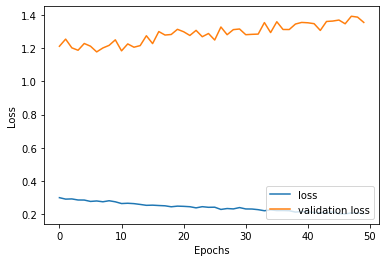

In [42]:
plot.plot(history.history['loss'], label='loss') 
plot.plot(history.history['val_loss'], label='validation loss')
plot.xlabel('Epochs')
plot.ylabel('Loss')
plot.legend(loc = 'lower right')